<a href="https://colab.research.google.com/github/Pavel-Pyvovar/ml_iasa_2020/blob/master/ml_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практикум 5. Побудова асоцiативних правил за алгоритмами Apriori та FP-росту**

### Варіант 14

# Хід виконання роботи

1. Взяти файл з даними у вiдповiдностi з варiантом.

2. Побудувати частi набори та асоцiативнi правила (АП), використовуючи алгоритм `Apriori`. Дослiдити множини АП залежно вiд параметрiв побудови АП: мiнiмальної пiдтримки `min_support`, мiнiмальної достовiрностi `min_threshold` `confidence` та максимальної потужностi частих наборiв `max_len`. Пiдiбрати значення параметрiв алгоритму Apriori, якi призводять до значущих АП. АП $R_{k}$ вважати значущим, якщо покращення (improvement або лiфт (lift)): $Improv(R_{k}) > 1$.

3. Побудувати частi набори та множину АП, використовуючи алгоритм FP-росту. Дослiдити множини АП залежно вiд параметрiв побудови АП, якi було наведено вище для Apriori. Пiдiбрати значення параметрiв алгоритму FP-росту, якi призводять до значущих АП.

4. Зробити висновки щодо впливу параметрiв алгоритмiв Apriori та FP-росту на знайденi множини асоціативних правил (АП).

5. Знайти значення прогнозу на основi побудованої множини правил.

6. Порiвняти результати, отриманi алгоритмами Apriori та FP-росту.

Дозволяється використати наступнi матерiали:
* http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/
* https://www.kaggle.com/povilass/analysis-of-transactions-from-a-bakery-and-apriori

# 1. Взяти файл з даними у вiдповiдностi з варiантом.

In [0]:
!pip show mlxtend

Name: mlxtend
Version: 0.14.0
Summary: Machine Learning Library Extensions
Home-page: https://github.com/rasbt/mlxtend
Author: Sebastian Raschka
Author-email: mail@sebastianraschka.com
License: BSD 3-Clause
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, scikit-learn, matplotlib, pandas, setuptools, numpy
Required-by: 


Для повторення результатів роботи потрібно мати версію пакету `mlxtend` новішу за 0.14.0. При роботі у Google Colabrotory для цього достатньо буде виконати наступну команду: 

In [0]:
!pip install --upgrade mlxtend

In [0]:
!pip show mlxtend

Name: mlxtend
Version: 0.17.2
Summary: Machine Learning Library Extensions
Home-page: https://github.com/rasbt/mlxtend
Author: Sebastian Raschka
Author-email: mail@sebastianraschka.com
License: BSD 3-Clause
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, numpy, pandas, scikit-learn, matplotlib, joblib, setuptools
Required-by: 


In [0]:
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
import pandas as pd
import time
import warnings

np.set_printoptions(linewidth=100, suppress=True, precision=3)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 100)

Імпортуємо вхідні дані. Традиційно в задачі пошуку АП маємо: множину $I = (i_{1}, ...,i_{m})$ предметів, для даного набору даних `Var_6_1000_Transactions` -- ідентифікаторів продуктів `product_id`, множину $D$ транзакцій в якій кожена транзакція $T$ -- множина елементів, таких що $T \subset I$. Кожній транзакції ставиться у відповідність унікальний ідентифікатор $TID$, в даному випадку -- `order_id`. Оскільки функції `apriori` `fpgrowth` при використанні параметра `use_colnames` вимагають колонки строкового типу, то при імпортуванні даних за допомогою функції `pd.read_csv` необхідно задати параметр `dtype`[[1]](http://rakesh.agrawal-family.com/papers/vldb94apriori.pdf).

In [0]:
transactions = pd.read_csv('Var_6_1000_Transactions.csv',
                           dtype={'product_id': str, 'order_id': str})

Подубуємо кругову діаграму для двадцяти найчастіших продуктів із вибірки.

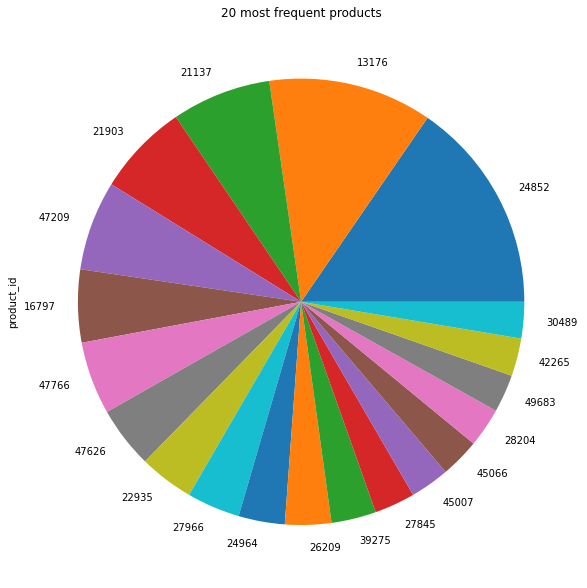

In [0]:
transactions.product_id.value_counts().head(20)\
            .plot.pie(figsize=(10, 15), title='20 most frequent products')
plt.show()

Побудуємо гістограму для того, щоб краще зрозуміти, які товари покупці часто придбають.

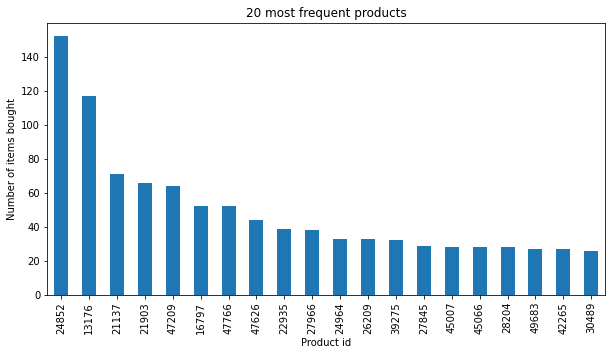

In [0]:
transactions.product_id.value_counts().head(20).plot.bar(figsize=(10, 5))
plt.xlabel('Product id')
plt.ylabel('Number of items bought')
plt.title('20 most frequent products')
plt.show()

Кількість унікальних продуктів вибірки:

In [0]:
len(transactions.product_id.unique())

4438

Кількість унікальних замовлень (транзакцій):

In [0]:
len(transactions.order_id.unique())

956

In [0]:
transactions.head()

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


Для того, щоб отримати множину найчастіших наборів, вхідні дані спочатку необхідно привести до закодованого вигляду.

In [0]:
def encode(df, product_id, tid):
    '''Method to convert transactions database data into sparse encoded form.

    Parameters
    -------------
    df: pandas.DataFrame
        Table containg transaction ids (user ids) and product ids bought.
    product_id: str
        The name of the column containing product ids.
    tid: str
        The name of the column containing transaction (user) ids.
    
    Returns
    -------------
    transaction_product_df: pandas.DataFrame
        Table with columns as product ids and rows as transaction ids. A cell at
        the intersection of row i and column j contains True if during 
        transaction i product j was bought.
    '''    
    itemsets = df.groupby(by=tid)[product_id].agg(lambda x: list(x)).to_list()
    te = TransactionEncoder()
    sparse_itemsets = te.fit_transform(itemsets, sparse=True)
    transaction_product_df = pd.DataFrame.sparse.from_spmatrix(sparse_itemsets,
                                columns=te.columns_, index=df[tid].unique())
    return transaction_product_df
    
order_product_df = encode(transactions, 'product_id', 'order_id')

# 2. Aлгоритм Apriori

## Опис алгоритму

### Позначення:
* $L_{k}$: Множина найблільших (частих) k-елементних наборів (з мінімальною підтримкою). Кожен елемент множини має два атрибути: набір та значення підтримки.
* $C_{k}$: Множина кандидатів в k-елементні часті набори, отримана
шляхом зв’язування множини $L_{k-1}$ з собою. Кожен елемент множини має два атрибути: набір та значення підтримки.

### Псевдокод
$ 1)  L_{1}=\{\text { large } 1 \text {-itemsets }\}$

$ 2) \text { for }  \left(k=2 ; L_{k-1} \neq \emptyset ; k++\right) \text { do begin } $

$ 3) \quad C_{k} =  \text {apriori-gen} \left(L_{k-1}\right) ; \quad \text {// New candidates}$

$4)\quad \text { for all transactions } t \in \mathcal{D} \text { do begin }$

$5)\quad \quad C_{t}=\operatorname{subset}\left(C_{k}, t\right) ;  \text { // Candidates contained in } t$

$6)\quad \quad \text { forall candidates } c \in C_{t} \text { do } $

$7) \quad \quad \quad c . count ++ $

$8)\quad \quad end$

$9) \quad \quad L_{k}=\left\{c \in C_{k} | c . count \geq \operatorname{minsup}\right\}$

$10) end$

$11) Answer =\bigcup_{k} L_{k} $

The first pass of the algorithm simply counts item occurrences to determine the large 1-itemsets. A subsequent pass, say pass  $k$ consists of two phases. First, the large itemsets $L_{k-1}$ found in the $(k-1)th$ pass are used to generate the candidate itemsets $ C_{k}$ using the apriorigen function described in Section 2.1.1. Next the database is scanned and the support of candidates in $C_{k}$ is counted. For fast counting, we need to efficiently determine the candidates in $C_{k}$ that are contained in a given transaction $t$. Section 2.1.2 describes the subset function used for this purpose.

### 2.1.1 Генерація кандидатів

Функція apriori-gen приймає як аргумент $L_{k-1}$, множина частих (k-1)-елементних наборів. Вона повертає надмножину множини всіх частих k-елементних наборів. Функція працює наступним чином. По-перше, на кроці *join*, поєдується $L_{k-1}$ з $L_{k-1}$: 

$ \text { insert into } C_{k}$

$ \text { select } p.item_{1}, p.item_{2}, \ldots, p.item_{k-1}, q.item_{k-1} $ 

$ \text { from } L_{k-1} p, L_{k-1} q $

$ \text { where } p.item_{1}=q.item_{1}, \ldots, p.item_{k-2}=q.item_{k-2}, 
p.item_{k-1}<q.item_{k-1} $

Далі, на кроці "підрізання", видаляються всі набори $ c \in C_{k} $ так що деяка (k-1)-підмножина c не належить $ L_{k-1} $:

$ \text { for all itemsets } c \in C_{k} do $

$ \quad \text { for all (k-1)-subsets s of c do } $

$ \quad \quad if \left(s \notin L_{k-1}\right) then $

$ \quad \quad \quad \text { delete c from } C_{k} $

Побудуємо часті набори за допомогою алгоритму `Apriori`, проведемо дослiдження пареметру мiнiмальної пiдтримки `min_support`:

In [44]:
%time
frequent_itemsets = apriori(order_product_df, use_colnames=True,
                            min_support=.01)
frequent_itemsets

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


,support,itemsets
0,0.013598,(10749)
1,0.013598,(11520)
2,0.010460,(1158)
3,0.014644,(12341)
4,0.122385,(13176)
...,...,...
130,0.011506,"(45066, 24852)"
131,0.010460,"(24852, 47626)"
132,0.016736,"(24852, 47766)"
133,0.010460,"(49683, 24852)"


In [0]:
%time
apriori(order_product_df, use_colnames=True, min_support=.05)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


,support,itemsets
0,0.122385,(13176)
1,0.054393,(16797)
2,0.074268,(21137)
3,0.069038,(21903)
4,0.158996,(24852)
5,0.066946,(47209)
6,0.054393,(47766)


In [0]:
%time
apriori(order_product_df, use_colnames=True, min_support=.03)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


,support,itemsets
0,0.122385,(13176)
1,0.054393,(16797)
2,0.074268,(21137)
3,0.069038,(21903)
4,0.040795,(22935)
5,0.158996,(24852)
6,0.034519,(24964)
7,0.034519,(26209)
8,0.030335,(27845)
9,0.039749,(27966)


Побудуємо АП за допомогою алгоритму `Apriori`, проведемо дослідження мiнiмальної достовiрностi `min_threshold` та максимальної потужностi частих наборiв `max_len`:

In [0]:
%%time
association_rules(frequent_itemsets, min_threshold=.1)

CPU times: user 8.08 ms, sys: 0 ns, total: 8.08 ms
Wall time: 9.96 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(21137),(13176),0.074268,0.122385,0.019874,0.267606,2.186590,0.010785,1.198282
1,(13176),(21137),0.122385,0.074268,0.019874,0.162393,2.186590,0.010785,1.105211
2,(22935),(13176),0.040795,0.122385,0.010460,0.256410,2.095113,0.005468,1.180241
3,(27966),(13176),0.039749,0.122385,0.015690,0.394737,3.225371,0.010826,1.449973
4,(13176),(27966),0.122385,0.039749,0.015690,0.128205,3.225371,0.010826,1.101464
5,(47209),(13176),0.066946,0.122385,0.023013,0.343750,2.808761,0.014819,1.337318
6,(13176),(47209),0.122385,0.066946,0.023013,0.188034,2.808761,0.014819,1.149130
7,(16797),(24852),0.054393,0.158996,0.012552,0.230769,1.451417,0.003904,1.093305
8,(16797),(43352),0.054393,0.027197,0.010460,0.192308,7.071006,0.008981,1.204423
9,(43352),(16797),0.027197,0.054393,0.010460,0.384615,7.071006,0.008981,1.536611


Як бачимо з таблиці вище, серед АП присутні такі, що мають значення покращення менше за 1, такі правила вважаємо не значущими, їх необхідно видалити.

In [45]:
%%time
apriori_ar = association_rules(frequent_itemsets, min_threshold=.3)
apriori_ar = apriori_ar[apriori_ar.lift > 1]
apriori_ar = apriori_ar[['antecedents', 'consequents',
                         'support', 'confidence', 'lift']]

CPU times: user 10.3 ms, sys: 1.04 ms, total: 11.3 ms
Wall time: 10.3 ms


In [0]:
apriori_ar

,antecedents,consequents,support,confidence,lift
0,(27966),(13176),0.015690,0.394737,3.225371
1,(47209),(13176),0.023013,0.343750,2.808761
2,(43352),(16797),0.010460,0.384615,7.071006
3,(21903),(24852),0.025105,0.363636,2.287081
4,(27845),(24852),0.011506,0.379310,2.385662
5,(28204),(24852),0.014644,0.500000,3.144737
6,(45066),(24852),0.011506,0.392857,2.470865
7,(47766),(24852),0.016736,0.307692,1.935223
8,(49683),(24852),0.010460,0.370370,2.329435
9,(9076),(24852),0.010460,0.454545,2.858852


In [0]:
%%time
association_rules(frequent_itemsets, min_threshold=.4)

CPU times: user 6.69 ms, sys: 52 µs, total: 6.74 ms
Wall time: 6.57 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(28204),(24852),0.029289,0.158996,0.014644,0.500000,3.144737,0.009988,1.682008
1,(9076),(24852),0.023013,0.158996,0.010460,0.454545,2.858852,0.006801,1.541841


In [0]:
%%time
association_rules(frequent_itemsets, min_threshold=.5)

CPU times: user 7.78 ms, sys: 0 ns, total: 7.78 ms
Wall time: 8.66 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(28204),(24852),0.029289,0.158996,0.014644,0.5,3.144737,0.009988,1.682008


Як бачимо з останніх двох таблиць, при збільшенні параметру `min_threshold` від 0.1 до 0.5 кількість АП стрімко зменшується. При цьому відсоток значущих наборів серед них збільшується. 

# 3. Алгоритм FP-росту

**Input**: База даних DB, представлена як FP-дерево побудоване відповідно до алгоритму описаному в [2], та мінімальний поріг підтримки $\xi$. 

**Output**: Повна множина частих наборів.

## Псевдокод алгоритму:

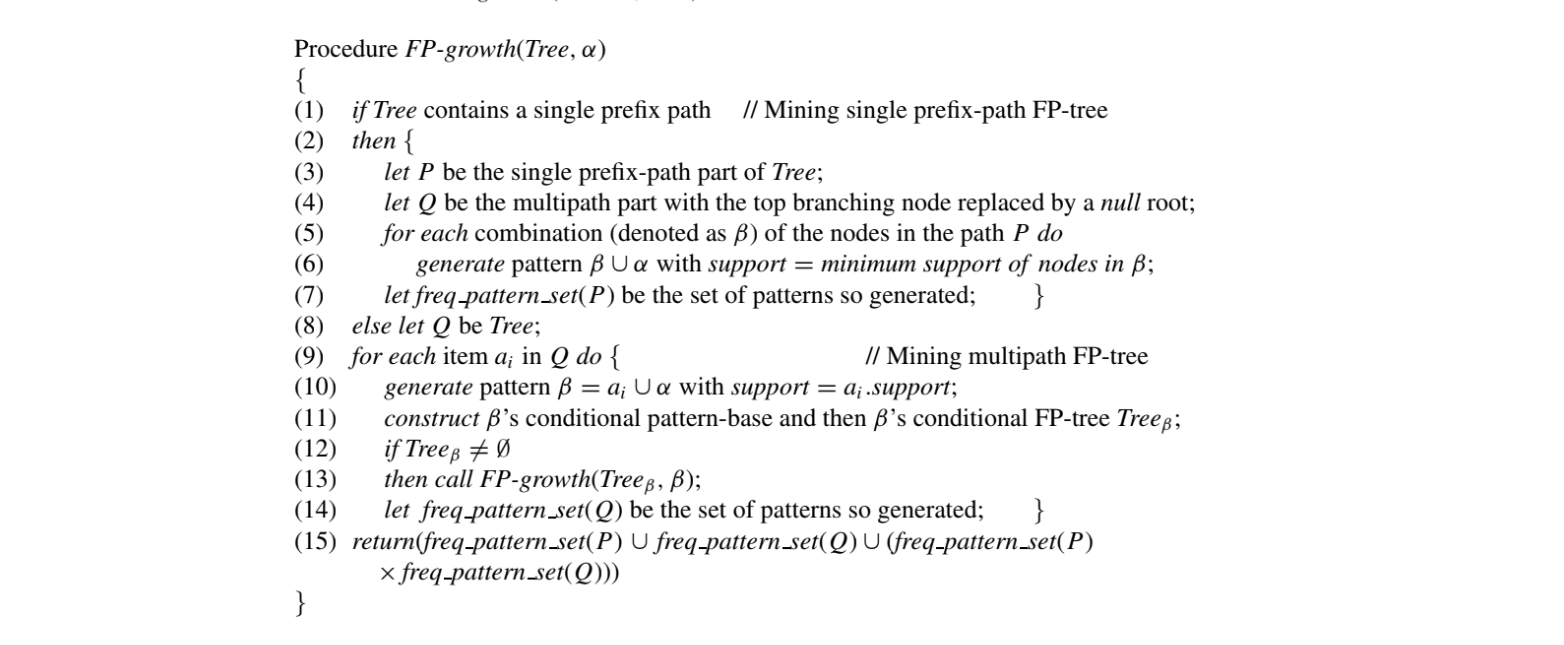

Дослiдити множини АП залежно вiд параметрiв побудови АП, якi було наведено вище для Apriori. Пiдiбрати значення параметрiв алгоритму FP-росту, якi призводять до значущих АП.

In [119]:
%%time
frequent_itemsets = fpgrowth(order_product_df, use_colnames=True,
                             min_support=.01)

CPU times: user 161 ms, sys: 6.84 ms, total: 168 ms
Wall time: 169 ms


In [0]:
frequent_itemsets

,support,itemsets
0,0.158996,(24852)
1,0.074268,(21137)
2,0.054393,(47766)
3,0.021967,(31717)
4,0.019874,(4605)
...,...,...
130,0.010460,"(24852, 9076)"
131,0.011506,"(27845, 24852)"
132,0.010460,"(13176, 22935)"
133,0.011506,"(45066, 24852)"


In [0]:
%%time
fpgrowth(order_product_df, use_colnames=True, min_support=.03)

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 125 ms


,support,itemsets
0,0.158996,(24852)
1,0.074268,(21137)
2,0.054393,(47766)
3,0.046025,(47626)
4,0.039749,(27966)
5,0.122385,(13176)
6,0.054393,(16797)
7,0.069038,(21903)
8,0.066946,(47209)
9,0.030335,(27845)


In [0]:
%%time
fpgrowth(order_product_df, use_colnames=True, min_support=.05)

CPU times: user 121 ms, sys: 758 µs, total: 122 ms
Wall time: 126 ms


,support,itemsets
0,0.158996,(24852)
1,0.074268,(21137)
2,0.054393,(47766)
3,0.122385,(13176)
4,0.054393,(16797)
5,0.069038,(21903)
6,0.066946,(47209)


In [0]:
%%time
association_rules(frequent_itemsets, metric='confidence', min_threshold=.1)

CPU times: user 6.11 ms, sys: 1 µs, total: 6.12 ms
Wall time: 5.41 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(21137),(24852),0.074268,0.158996,0.011506,0.154930,0.974426,-0.000302,0.995188
1,(21137),(13176),0.074268,0.122385,0.019874,0.267606,2.186590,0.010785,1.198282
2,(13176),(21137),0.122385,0.074268,0.019874,0.162393,2.186590,0.010785,1.105211
3,(47766),(24852),0.054393,0.158996,0.016736,0.307692,1.935223,0.008088,1.214784
4,(24852),(47766),0.158996,0.054393,0.016736,0.105263,1.935223,0.008088,1.056855
5,(47626),(24852),0.046025,0.158996,0.010460,0.227273,1.429426,0.003142,1.088358
6,(27966),(13176),0.039749,0.122385,0.015690,0.394737,3.225371,0.010826,1.449973
7,(13176),(27966),0.122385,0.039749,0.015690,0.128205,3.225371,0.010826,1.101464
8,(28204),(24852),0.029289,0.158996,0.014644,0.500000,3.144737,0.009988,1.682008
9,(16797),(24852),0.054393,0.158996,0.012552,0.230769,1.451417,0.003904,1.093305


In [120]:
%%time
fp_growth_ar = association_rules(frequent_itemsets, metric='confidence', 
                               min_threshold=.3)
fp_growth_ar = fp_growth_ar[fp_growth_ar.lift > 1]
fp_growth_ar = fp_growth_ar[['antecedents', 'consequents',
                             'support', 'confidence', 'lift']]

CPU times: user 10.1 ms, sys: 1.96 ms, total: 12.1 ms
Wall time: 11.2 ms


In [0]:
fp_growth_ar

,antecedents,consequents,support,confidence,lift
0,(47766),(24852),0.016736,0.307692,1.935223
1,(27966),(13176),0.015690,0.394737,3.225371
2,(28204),(24852),0.014644,0.500000,3.144737
3,(49683),(24852),0.010460,0.370370,2.329435
4,(21903),(24852),0.025105,0.363636,2.287081
5,(47209),(13176),0.023013,0.343750,2.808761
6,(9076),(24852),0.010460,0.454545,2.858852
7,(27845),(24852),0.011506,0.379310,2.385662
8,(45066),(24852),0.011506,0.392857,2.470865
9,(43352),(16797),0.010460,0.384615,7.071006


In [0]:
association_rules(frequent_itemsets, metric='confidence', min_threshold=.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(28204),(24852),0.029289,0.158996,0.014644,0.500000,3.144737,0.009988,1.682008
1,(9076),(24852),0.023013,0.158996,0.010460,0.454545,2.858852,0.006801,1.541841


In [0]:
association_rules(frequent_itemsets, metric='confidence', min_threshold=.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(28204),(24852),0.029289,0.158996,0.014644,0.5,3.144737,0.009988,1.682008


Для алгоритму FP-росту спостерігаємо результат аналогічний попередньому. Зі збільшенням рівня порогу зменшується кількість АП та збільшується відсоток значущих серед них.

# 4. Зробити висновки щодо впливу параметрiв алгоритмiв Apriori та FP-росту на знайденi множини АП.

По-перше, через відносно невелику величину набору даних для знаходження значущих АП необхідно надати невелике значення мінімальній підтримці. Інакше не вдається знайти ні одним алгоритмом значущі АП. 

По-друге, отримані часті набори містять невелку кількість продуктів, не більше двох. Тому для даної вибірки, налагодження параметру `max_len`, що встановлює максимальну потужність частих наборів не є доцільним.


# 5. Знайти значення прогнозу на основi побудованої множини правил

Симулюємо ситуацію, коли покупець прийшов у магазин придбати певні товари з тих, що занесені у БД. За допомогою алгоритмів вище було знайдено АП, що можуть допомогти порекомендувати покупцю додатковий товар залежно від того, що вже є у кошику.


In [0]:
def predict(assoc_rules, itemset):
    '''
    Make suggestions of products for the customer based on association rules
    learned. If no rule corresponds to given itemset, the same itemset is 
    returned.

    Parameters
    -----------
    ar: list
        Association rules learned from previous transactions data. List contains
        frozen sets of string ids of products customers often buy together. A
        frozen set is the same as python set but immutable.
    itemset: list
        Product(s) the customer is going to buy.

    Returns
    -----------
    matching_ar: list
        Association rules that matched given itemset.
    '''
    matching_ar = pd.DataFrame()
    for item in itemset:
        ar = assoc_rules.loc[assoc_rules.antecedents.apply(lambda x: item in x)]
        if not ar.empty:
            matching_ar = pd.concat([matching_ar, ar])
    return matching_ar

Виберемо 100 довільних товарів та знайдемо товари, що часто разом з ними придбаються використовуючи АП знайдені за допомогою алгоритму `Apriori`:

In [124]:
predict(apriori_ar, transactions.product_id.sample(n=100).to_list())

,antecedents,consequents,support,confidence,lift
8,(49683),(24852),0.010460,0.37037,2.329435
4,(27845),(24852),0.011506,0.37931,2.385662
1,(47209),(13176),0.023013,0.34375,2.808761


Повторимо аналогічний експеримент для АП алгоритму FP-росту:

In [123]:
predict(fp_growth_ar, transactions.product_id.sample(n=100).to_list())

,antecedents,consequents,support,confidence,lift
8,(45066),(24852),0.011506,0.392857,2.470865
0,(47766),(24852),0.016736,0.307692,1.935223
0,(47766),(24852),0.016736,0.307692,1.935223
7,(27845),(24852),0.011506,0.379310,2.385662


# 6. Порiвняти результати, отриманi алгоритмами Apriori та FP-росту.

Підсумовуючи, слід зазначити, що як і сказано у роботі [[2]](https://doi.org/10.1023/B:DAMI.0000005258.31418.83) алгоритм FP-росту швидший за алгоритм Аpriori. Час роботи алгоритму Аpriori для різних варіантів підбору параметрів наведений у кодових клітинках за допомогою "магічної функції" %%time. 

## Посилання:
1. Agrawal, Rakesh; and Srikant, Ramakrishnan; [Fast algorithms for mining association rules in large databases](http://rakesh.agrawal-family.com/papers/vldb94apriori.pdf) Archived 2015-02-25 at the Wayback Machine, in Bocca, Jorge B.; Jarke, Matthias; and Zaniolo, Carlo; editors, Proceedings of the 20th International Conference on Very Large Data Bases (VLDB), Santiago, Chile, September 1994, pages 487-499
2. Han, J., Pei, J., Yin, Y. et al. Mining Frequent Patterns without Candidate Generation: A Frequent-Pattern Tree Approach. Data Mining and Knowledge Discovery 8, 53–87 (2004). https://doi.org/10.1023/B:DAMI.0000005258.31418.83